(1, 1024, 1024)
(20, 20)
(99, 1024, 1024)
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 35983.8022542175 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory C:\Users\benlc\PASP_HCItutorial-main\FM_data
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
Raw X/Y Centroid = (26.20819304740155, 189.95685129867167) with statistical error of [-0.19714629  0.14373441] pix in X and [-0.35983626  0.19195406] pix in Y
Raw Sep/PA Centroid = (191.75547642841266, 7.85693119278554) with statistical error of [ 0.18423849 -0.33766768] pix in Sep and [ 0.06533523 -0.04667186] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity


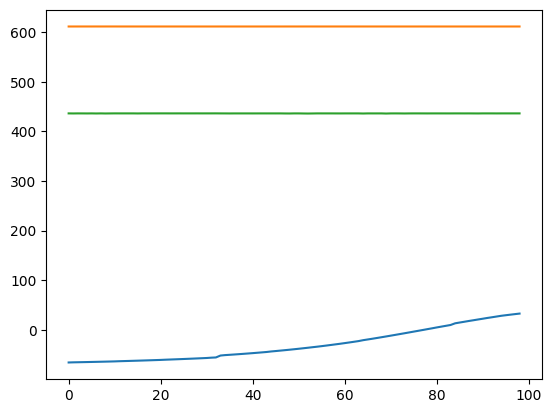

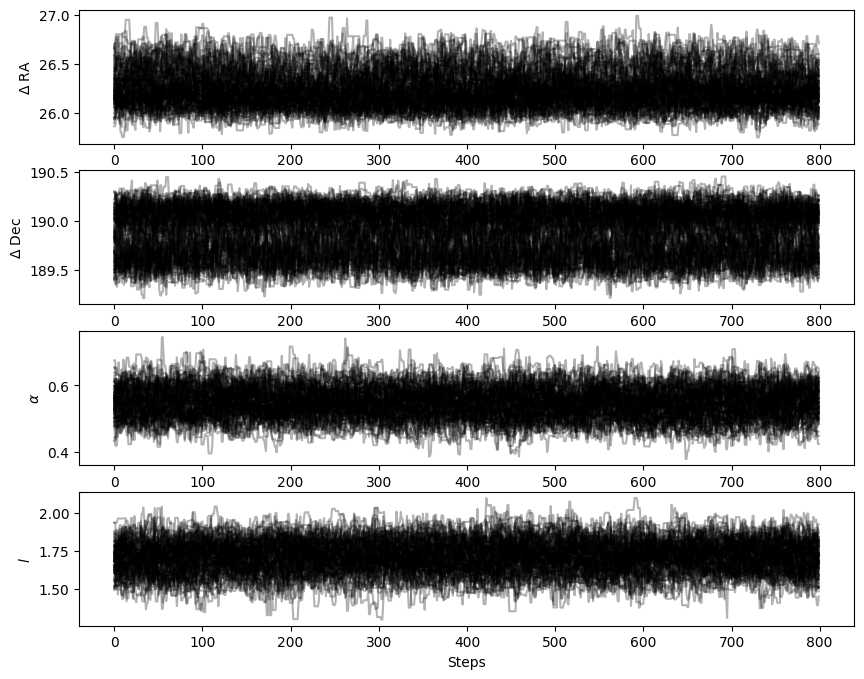

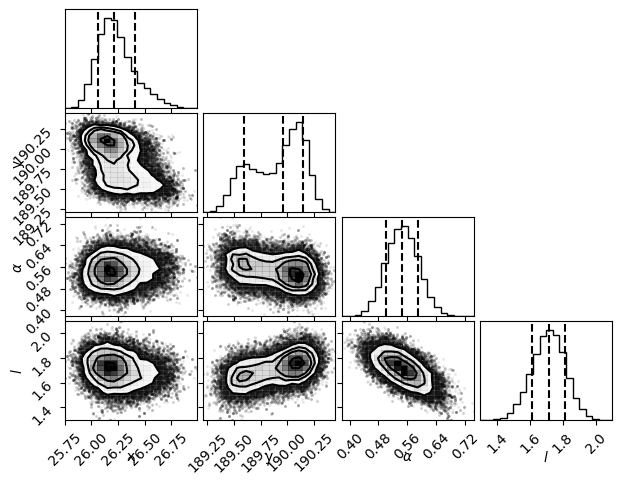

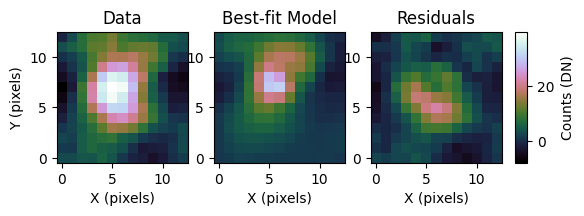

In [2]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
%matplotlib inline

warnings.filterwarnings("ignore")

#returns median of aligned images to use as PSF
def ADI_psfs(psflist):  #add parangs to GenericData constructor
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            

    fits.writeto('rawexample.fits',rawpsfs[1,:,:], overwrite=True)
    fits.writeto('alignedexample.fits',alignedpsfs[1,691:711,477:497], overwrite=True)
    medpsfs = np.nanmedian(alignedpsfs, axis=0)
    fits.writeto('psfs.fits', medpsfs[691:711, 477:497], overwrite=True)

    
    return np.array([medpsfs])

    



#returns fits-processed images, centers, and parallactic angles for every file in the list with given dimensions
def ADI_getImages(flist, xdim, ydim):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        #find centers
        if i == 0:
            ctrs[i][0] = 611.4
            ctrs[i][1] = 436.2
            fits.writeto('centerNotFlipped.fits', rawcube[0, 591:631, 416:456], overwrite=True)
            fits.writeto('centerFlipped.fits', rawcube[0, 416:456, 591:631],overwrite=True)
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0]
            ctrs[i][1] = ctrs[0][1] - shifts[1]
            
        parangs[i] = head['PARANG']

    plt.plot(parangs)
    plt.plot(ctrs)
    return rawcube, ctrs, parangs
        
    
#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
            print(head)
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)
    
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    #plt.plot(ctrs)
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]

#ADI
def ADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    ctrs= np.zeros((len(flist),2))
    parangs=np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        #find centers
        if i == 0:
            ctrs[i][0] = 600
            ctrs[i][1] = 455
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0]
            ctrs[i][1] = ctrs[0][1] - shifts[1]  ##this allows the centers to be different, just to see what pyklip will do -- alternative is to make an N length array with every element equalling the first ctrs[0]

        #ctrs[i][0] = 600
        #ctrs[i][1] = 455
        #find parangs
        parangs[i] = head['PARANG']
        
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='KLIP_Processing/CH4',
                                        annuli=9,subsections=4,numbasis=[1,20,50,100],maxnumbasis=150,mode="ADI",
                                        movement=1)
    
    #plt.plot(ctrs)
    #plt.plot(parangs)
    #sub_imgs = parallelized.klip_dataset(imgs,mode='ADI')
    return sub_imgs, ctrs[0]


#Forward-Modeling
def forwardmodel(flist, psflist):
    instrument_psfs = ADI_psfs(psflist) #DiskFM, use data sent to u
    print(instrument_psfs.shape)
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    fits.writeto('datacube', datacube[0], overwrite=True)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)
    #fits.writeto('dataset.fits', dataset[0], overwrite=True)


    #NIRC2.NIRC2Data(flist) -> GenericData(flist)
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 190.9
    guesspa = 8.1
    guessflux = 1.0
    fm_psf_stamp = instrument_psfs[0, 691:711, 477:497]
    
    print(fm_psf_stamp.shape)
    fm_psf_stamp = fm_psf_stamp.reshape(1, fm_psf_stamp.shape[0], fm_psf_stamp.shape[1])

    fits.writeto('psf_stamp.fits', fm_psf_stamp[0], overwrite=True)
    print(dataset.input.shape)

    """def transmission_correction(input_stamp, input_dx, input_dy):
        
        #Args:
        #    input_stamp (array): 2D array of the region surrounding the fake planet injection site
        #   input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
        #    input_dy (array): 2D array specifying the y distance of each stamp pixel from the center
    
        #Returns:
        #    output_stamp (array): 2D array of the throughput corrected planet injection site.
        
        # Calculate the distance of each pixel in the input stamp from the center
        distance_from_center = np.sqrt((input_dx)**2+(input_dy)**2)
    
        # Select the relevant columns from the coronagraph's transmission profile
        transmission =  transmission_profile['throughput']
        radius = transmission_profile['distance']
    
        # Interpolate to find the transmission value for each pixel in the input stamp
        transmission_of_stamp = np.interp(distance_from_center, radius, transmission)
    
        # Reshape the interpolated array to have the same dimensions as the input stamp
        transmission_of_stamp = transmission_of_stamp.reshape(input_stamp.shape)
    
        # Make the throughput correction
        output_stamp = transmission_of_stamp*input_stamp
    
        return output_stamp"""
        
    fm_class = fmpsf.FMPlanetPSF(fm_psf_stamp.shape, numbasis, guesssep, guesspa, guessflux, fm_psf_stamp,
                             input_wvs = np.unique(dataset.wvs), flux_conversion = [1]*datacube.shape[0])
                            #, field_dependent_correction = transmission_correction) #check docs 
    
    
    outputdir = "./FM_data" # where to write the output files
    prefix = "hd47127-h-fmpsf" # fileprefix for the output files
    annulus_bounds = [[guesssep-15, guesssep+15]] # one annulus centered on the planet
    subsections = 1 # we are not breaking up the annulus
    padding = 0 # we are not padding our zones
    movement = 4 # we are using an conservative exclusion criteria of 4 pixels
    
    # run KLIP-FM
    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)

    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs
    output_prefix = './FM_data/hd47127-h-fmpsf'
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")
    
    # get FM frame
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']
    
    # get data_stamp frame
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]
    
    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']

    fit = fitpsf.FMAstrometry(guesssep, guesspa, 13, method="mcmc")
    fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)
    fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
    corr_len_guess = 3.
    corr_len_label = r"$l$"
    fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
    # set bounds
    x_range = 1.5 # pixels
    y_range = 1.5 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    
    # run MCMC fit
    fit.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=1)
    fig = plt.figure(figsize=(10,8))
    
    # grab the chains from the sampler
    chain = fit.sampler.chain
    
    # plot RA offset
    ax1 = fig.add_subplot(411)
    ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)
    ax1.set_xlabel("Steps")
    ax1.set_ylabel(r"$\Delta$ RA")
    
    # plot Dec offset
    ax2 = fig.add_subplot(412)
    ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
    ax2.set_xlabel("Steps")
    ax2.set_ylabel(r"$\Delta$ Dec")
    
    # plot flux scaling
    ax3 = fig.add_subplot(413)
    ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
    ax3.set_xlabel("Steps")
    ax3.set_ylabel(r"$\alpha$")
    
    # plot hyperparameters.. we only have one for this example: the correlation length
    ax4 = fig.add_subplot(414)
    ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
    ax4.set_xlabel("Steps")
    ax4.set_ylabel(r"$l$")

    fig = plt.figure()
    fig = fit.make_corner_plot(fig=fig)

    fig = plt.figure()
    fig = fit.best_fit_and_residuals(fig=fig)
    
    fit.propogate_errs(star_center_err=0.05, platescale=.01414, platescale_err=0.001, pa_offset=-0.1, pa_uncertainty=0.13)
    
    
    # show what the raw uncertainites are on the location of the planet
    print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fit.raw_RA_offset.bestfit, fit.raw_RA_offset.error,
                                                                                        fit.raw_Dec_offset.bestfit, fit.raw_Dec_offset.error))
    
    # Full error budget included
    print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.RA_offset.bestfit, fit.RA_offset.error))
    print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.Dec_offset.bestfit, fit.Dec_offset.error))
    
    # Propogate errors into separation and PA space
    print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fit.sep.bestfit, fit.sep.error))
    print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fit.PA.bestfit, fit.PA.error))


def diskForwardmodel(flist, psflist):
    instrument_psfs = ADI_psfs(psflist)
    print(instrument_psfs.shape)
    fits.writeto('instrument_psfs.fits', instrument_psfs[0][477:497][691:711], overwrite=True)
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    fits.writeto('datacube.fits', datacube[0], overwrite=True)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)

    numbasis = [3, 10, 20] #np.array
    aligned_center=[512, 512] #center of star? or planet? ---- how do the docs use the aligned_center parameter to construct the disk object?

    #nothing in the tutorial about estimating separation?
    diskobj = DiskFM(dataset.input.shape, numbasis, dataset, instrument_psfs,
                aligned_center=aligned_center)

    fm.klip_dataset(dataset, diskobj, outputdir="./DiskFM_Data", fileprefix="hd47127-h-fmpsf",
                numbasis=numbasis, maxnumbasis=20, aligned_center=aligned_center,
                mode='ADI', annuli=1, subsections=1, movement=1)

    
    
datadir='HD47127_data/Dec_2023/'
#datadir = 'HD47127_data/Feb_2023/'
#datadir = 'HD47127_data/HD47127/1024x1024_3coadds_10.0s_J + clear_31imgs/science_masked/'
#datadir = 'HD47127_data/HD47127/1024x1024_5coadds_6.0s_CH4_long + PK50_1.5_126imgs/science_masked/'
psfdir = 'newdata/HD47127/64x120_100coadds_0.01s_H + clear_40imgs/science_masked/'
#psfdir = 'newdata/HD47127/64x120_100coadds_0.01s_J + clear_40imgs/science_masked/'
#psfdir = 'newdata/HD47127/64x120_100coadds_0.01s_CH4_long + PK50_1.5_40imgs/'
flist = sorted(glob.glob(datadir + '*.fits'))
psflist = sorted(glob.glob(psfdir + '*.fits'))



#diskForwardmodel(flist, psflist)
forwardmodel(flist, psflist)
#flist_adi, cen = ADI_NIRC2(flist)